<a href="https://colab.research.google.com/github/vitamingyu/ml-for-Healthcare-Analytics/blob/main/breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import sys
print('Python: {}'.format(sys.version))
import scipy
import numpy
import matplotlib
import pandas
import sklearn
pkgs = [scipy, numpy, matplotlib, pandas, sklearn]
for pkg in pkgs:
  print(f'{pkg.__name__}: {pkg.__version__}')

Python: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
scipy: 1.11.3
numpy: 1.23.5
matplotlib: 3.7.1
pandas: 1.5.3
sklearn: 1.2.2


In [22]:
import numpy as np
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
# Load Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
names = ['id', 'clump_thickness', 'uniform_cell_size', 'uniform_cell_shape',
       'marginal_adhesion', 'single_epithelial_size', 'bare_nuclei',
       'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']
df = pd.read_csv(url, names=names)
# 대부분의 변수는 세포의 병리학적 특성에 관한 것, class는 해당 세포가 양성인지 악성인지 나타냄

In [24]:
# 데이터 전처리
df.replace('?', -99999, inplace=True)
print(df.axes) # 행과 열의 인덱스

[RangeIndex(start=0, stop=699, step=1), Index(['id', 'clump_thickness', 'uniform_cell_size', 'uniform_cell_shape',
       'marginal_adhesion', 'single_epithelial_size', 'bare_nuclei',
       'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class'],
      dtype='object')]


In [25]:
df.drop(columns='id', axis=1, inplace=True)
# 데이터셋 탐색
print(df.loc[10])

clump_thickness           1
uniform_cell_size         1
uniform_cell_shape        1
marginal_adhesion         1
single_epithelial_size    1
bare_nuclei               1
bland_chromatin           3
normal_nucleoli           1
mitoses                   1
class                     2
Name: 10, dtype: object


In [26]:
print(df.shape)
df.describe()

(699, 10)


,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_epithelial_size,bland_chromatin,normal_nucleoli,mitoses,class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


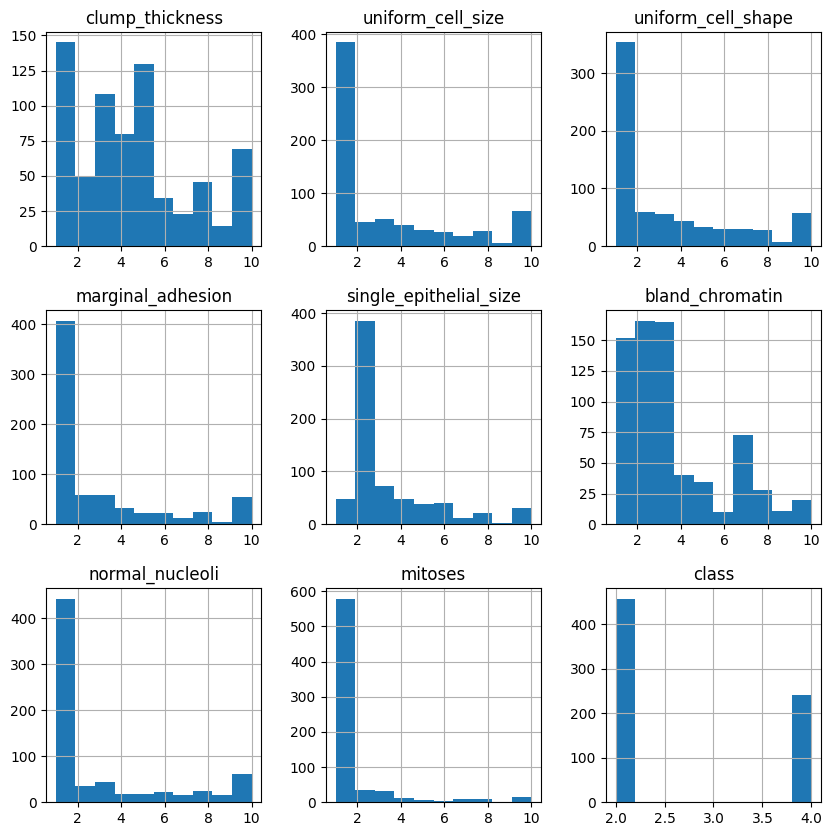

In [27]:
df.hist(figsize = (10, 10));
plt.show()

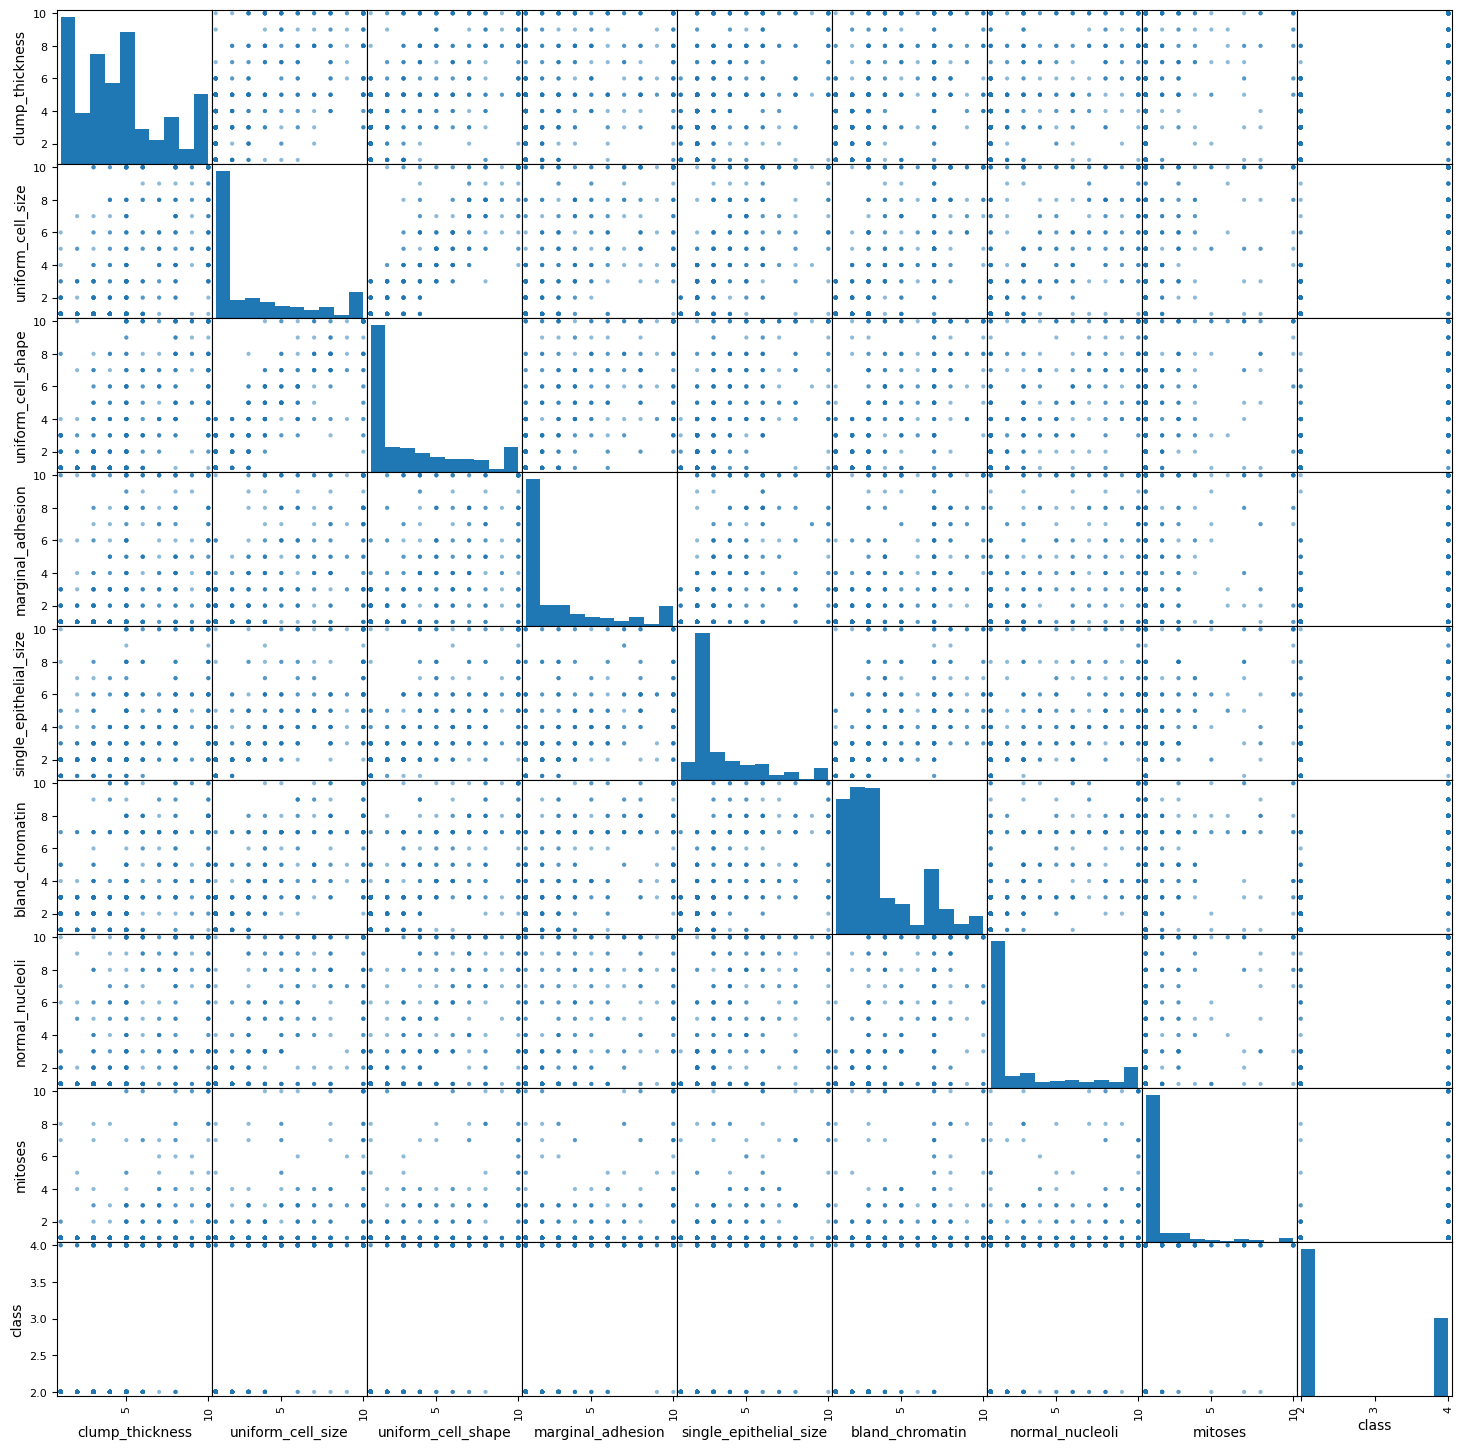

In [28]:
# 산점도 행렬 : 선형 모델을 선택하는 것이 좋을지 복잡한 모델을 선택하는 것이 좋을지 판단하는데 유용
scatter_matrix(df, figsize=(18,18))
plt.show()
# uniform_cell_shape와 uniform_cell_size는 강한 상관관계가 보이지만 다른 변수에선 뚜렷한 상관관계가 보이진 않는다

In [29]:
# 훈련, 테스트 데이터 나누기 (전체 데이터의 20%를 테스트로 사용)
x = np.array(df.drop(columns='class', axis=1))
y = np.array(df['class'])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2)

# 난수고정, 모델 성능지표로 정확도 사용
seed = 8
scoring = 'accuracy'

In [30]:
# K-근접 이웃과 SVM을 사용할 것임
# for문을 통해 두 모델을 동시에 훈련시키고 K-겹 교차검증을 시행한 후 그 결과인 평균값과 표준편차가 출력되게 코딩
# k-fold 교차검증 : 훈련데이터를 k값에 해당하는 n_splits개의 서브그룹으로 나누고, 서브그룹에서 하나를 제외한 후 학습시킨 다음, 제외했던 나머지 그룹으로 모델을 평가
# 이후 다른 하나를 제외한 후 같은 방법으로 모델을 훈련시키고 평가

# 모델정의
models = []
models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))  # 5개의 가장 가까운 이웃을 고려
models.append(('SVM', SVC(gamma='auto')))  # SVM 모델의 커널 계수 자동선택(?)

# 모델평가
results = []
names = []

for name, model in models:
  kfold = model_selection.KFold(n_splits=10)  # 10개의 서브그룹으로 나눔
  cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

KNN: 0.958929 (0.028849)
SVM: 0.949838 (0.026491)


In [31]:
# 테스트셋으로 예측하기
for name, model in models:
  model.fit(x_train, y_train)
  predictions = model.predict(x_test)
  print(f'{name}: {accuracy_score(y_test, predictions)}')
  print(classification_report(y_test, predictions))

# 정확도 = 전체 가운데 정확히 예측한 비율
# 정밀도(precision) - 결과가 양성일 것으로 예측되는 전체 가운데 정말로 양성인 비율
# 재현율(recall, sensitivity) - 실제로 양성 중 양성으로 예측한 비율
# F1값 - 정밀도와 재현율의 조화평균

KNN: 0.9928571428571429
              precision    recall  f1-score   support

           2       0.99      1.00      0.99        93
           4       1.00      0.98      0.99        47

    accuracy                           0.99       140
   macro avg       0.99      0.99      0.99       140
weighted avg       0.99      0.99      0.99       140

SVM: 0.9714285714285714
              precision    recall  f1-score   support

           2       1.00      0.96      0.98        93
           4       0.92      1.00      0.96        47

    accuracy                           0.97       140
   macro avg       0.96      0.98      0.97       140
weighted avg       0.97      0.97      0.97       140



In [32]:
#clf = SVC(gamma="auto")
clf = KNeighborsClassifier(n_neighbors=5)

clf.fit(x_train, y_train)
accuracy = clf.score(x_test, y_test)
print (accuracy)

example_measures = np.array([[4,2,1,1,2,1,2,1,1]])
example_measures = example_measures.reshape(len(example_measures), -1)  # 굳이 써줌으로써 코드의 일관성 유지 및 2차원배열임을 보장
prediction = clf.predict(example_measures)
print(prediction)

0.9928571428571429
[2]


In [33]:
print(df.loc[9])
# 예측결고 맞는 것으로 보임

clump_thickness           4
uniform_cell_size         2
uniform_cell_shape        1
marginal_adhesion         1
single_epithelial_size    2
bare_nuclei               1
bland_chromatin           2
normal_nucleoli           1
mitoses                   1
class                     2
Name: 9, dtype: object
